In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime

In [203]:
data_dir = '/Users/musa/Desktop/raspberrypi-recordings/recordings-3-15-25'

In [204]:
dirs = [d for d in Path(data_dir).iterdir() if d.is_dir()]
dirs.sort(key=lambda x: x.stem.split('-')[1:])
dirs

[PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-3-15-25/Grant-2025-03-08-02-20-05'),
 PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-3-15-25/Grant-2025-03-08-02-42-29')]

Grant-2025-03-08-02-42-29
(22156, 8) {'name': 'Grant', 'age': 22, 'weight': 190, 'sex': 'M', 'location': 'Studio fit', 'machine_weight': 80, 'start_time': 1741419749.0186148, 'notes': '', 'end_rep_markers': [4.1323370933532715, 9.277965307235718, 13.5, 17.845170259475708, 21.968807220458984, 27.280213356018066, 32.099074602127075, 37.36752963066101]}
Total reps: 8
Rep 1/8: 4.13 s
Rep 2/8: 5.15 s
Rep 3/8: 4.22 s
Rep 4/8: 4.35 s
Rep 5/8: 4.12 s
Rep 6/8: 5.31 s
Rep 7/8: 4.82 s
Rep 8/8: 5.27 s
(3818, 9)


Text(0.5, 0.98, 'Grant-2025-03-08-02-42-29')

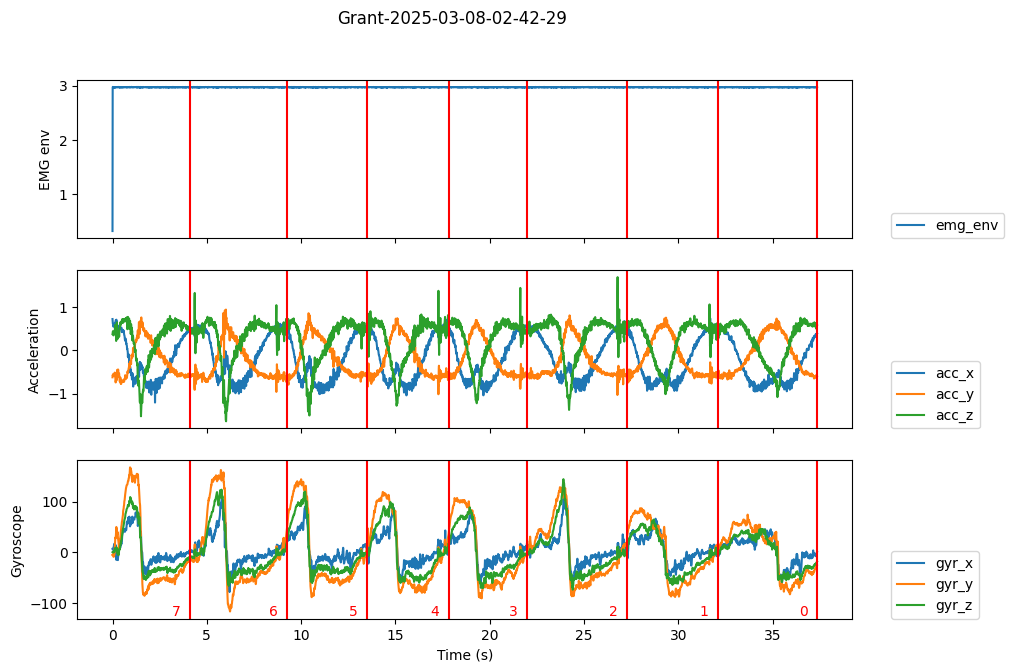

In [151]:
d = dirs[1]

print(d.name)
df = pd.read_csv(d / 'data.csv')
df['emg_env']
info = json.load(open(d / 'info.json'))
print(df.shape, info)

total_reps = len(info['end_rep_markers'])
print('Total reps:', total_reps)
df['rir'] = -1
print(f'Rep 1/{total_reps}: {info["end_rep_markers"][0]:.2f} s')
df.loc[df['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
    print(f'Rep {i+2}/{total_reps}: {end-start:.2f} s')
    df.loc[df['time'].between(start, end), 'rir'] = total_reps - i - 2
df = df[df['rir'] != -1]

i=0
df = df.iloc[int(i*100):]
print(df.shape)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(df['time'], df['emg_env'], label='emg_env')
axes[1].plot(df['time'], df[['acc_x', 'acc_y', 'acc_z']], label=['acc_x', 'acc_y', 'acc_z'])
axes[2].plot(df['time'], df[['gyr_x', 'gyr_y', 'gyr_z']], label=['gyr_x', 'gyr_y', 'gyr_z'])

axes[0].set_ylabel('EMG env')
axes[1].set_ylabel('Acceleration')
axes[2].set_ylabel('Gyroscope')
axes[2].set_xlabel('Time (s)')
[ax.legend(loc=(1.05, 0)) for ax in axes]

axes[2].set_xticks(np.arange(df['time'].iloc[0], df['time'].iloc[-1], 5))

for i,end_rep_mark in enumerate(info['end_rep_markers']):
    [ax.axvline(end_rep_mark, color='r') for ax in axes if end_rep_mark > df['time'].iloc[0]]
    axes[2].text(end_rep_mark - 0.5, 0.02, total_reps - i - 1, transform=axes[2].get_xaxis_transform(), color='r', horizontalalignment='right')

plt.suptitle(d.stem)

In [205]:
def label_rir(df, info):
    total_reps = len(info['end_rep_markers'])
    df['rir'] = -1
    df.loc[df['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
    for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
        df.loc[df['time'].between(start, end), 'rir'] = total_reps - i - 2
    df = df[df['rir'] != -1]

In [206]:
data_dirs = [
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-3-07-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-3-11-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-3-15-25',
]

In [208]:
not_labelled_each = [[0],[],[]]
dfs =[]
outdir = Path('data/')
outdir.mkdir(exist_ok=True, parents=True)
session_id = 0
for data_dir, not_labelled in zip(data_dirs, not_labelled_each):
    dirs = [d for d in Path(data_dir).iterdir() if d.is_dir()]
    for d in [dirs[i] for i in range(len(dirs)) if i not in not_labelled]:
        name = d.name.split('-')[0]
        df = pd.read_csv(d / 'data.csv')
        info = json.load(open(d / 'info.json'))
        label_rir(df, info)
        df['id'] = name
        df['session_id'] = session_id
        df = df[df['rir'] != -1]    # cut off after last rep
        dfs.append(df)
        session_id += 1
df = pd.concat(dfs)
df.to_csv(outdir / 'data.csv', index=False)

In [189]:
X = df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
y = df['rir'].values

In [190]:
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [191]:
hz = 100
X_windowed = []
y_windowed = []
window_t = 2.5
window_size = int(hz * window_t)    # 2.5 seconds
stride_t = 0.5
stride = int(hz * stride_t)         # 0.5 seconds
for i in range(0, len(X) - window_size, stride):
    X_windowed.append(X[i:i+window_size])
    y_windowed.append(y[i:i+window_size].mean())
X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)
print(X_windowed.shape, y_windowed.shape)

(2225, 250, 6) (2225,)


Text(0.5, 1.0, 'Rir=9.188')

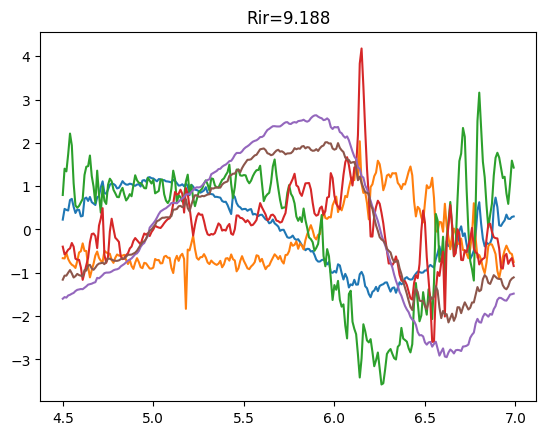

In [197]:
i = 9
plt.plot(X_windowed[i])
t = window_size / 5
tt = window_t / 5
plt.xticks(np.arange(0, window_size+1, t), np.arange(i*stride_t, i*stride_t + window_t + tt, tt));
plt.title(f'Rir={y_windowed[i]}')

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(1780, 250, 6) (445, 250, 6)


In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))
mean_squared_error(y_test, y_pred)

In [184]:
regr.rvalue**2

np.float64(0.6565194283398438)

Text(0, 0.5, 'Predicted RIR')

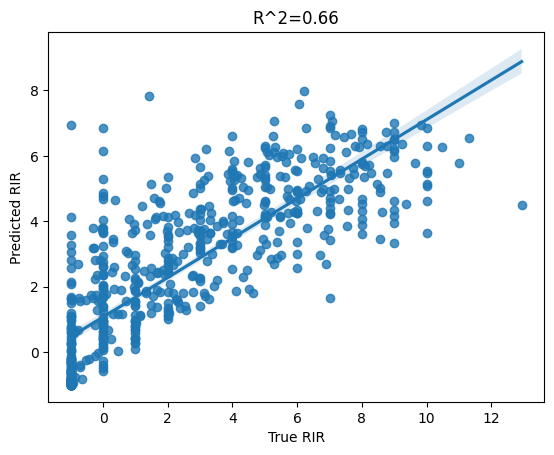

In [185]:
from scipy.stats import linregress
import seaborn as sns
regr = linregress(y_test, y_pred)
sns.regplot(x=y_test, y=y_pred)
plt.title(f'R^2={regr.rvalue**2:.2f}')
plt.xlabel('True RIR')
plt.ylabel('Predicted RIR')